In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

url = 'https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv'
df = pd.read_csv(url)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:

columns_to_fix = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[columns_to_fix] = df[columns_to_fix].replace(0, np.nan)

print("Missing values before imputation:")
print(df.isnull().sum())

df.fillna(df.median(), inplace=True)

print("Missing values after imputation:")
print(df.isnull().sum())

print("Dataset statistics:")
df.describe()


Missing values before imputation:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64
Missing values after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Dataset statistics:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


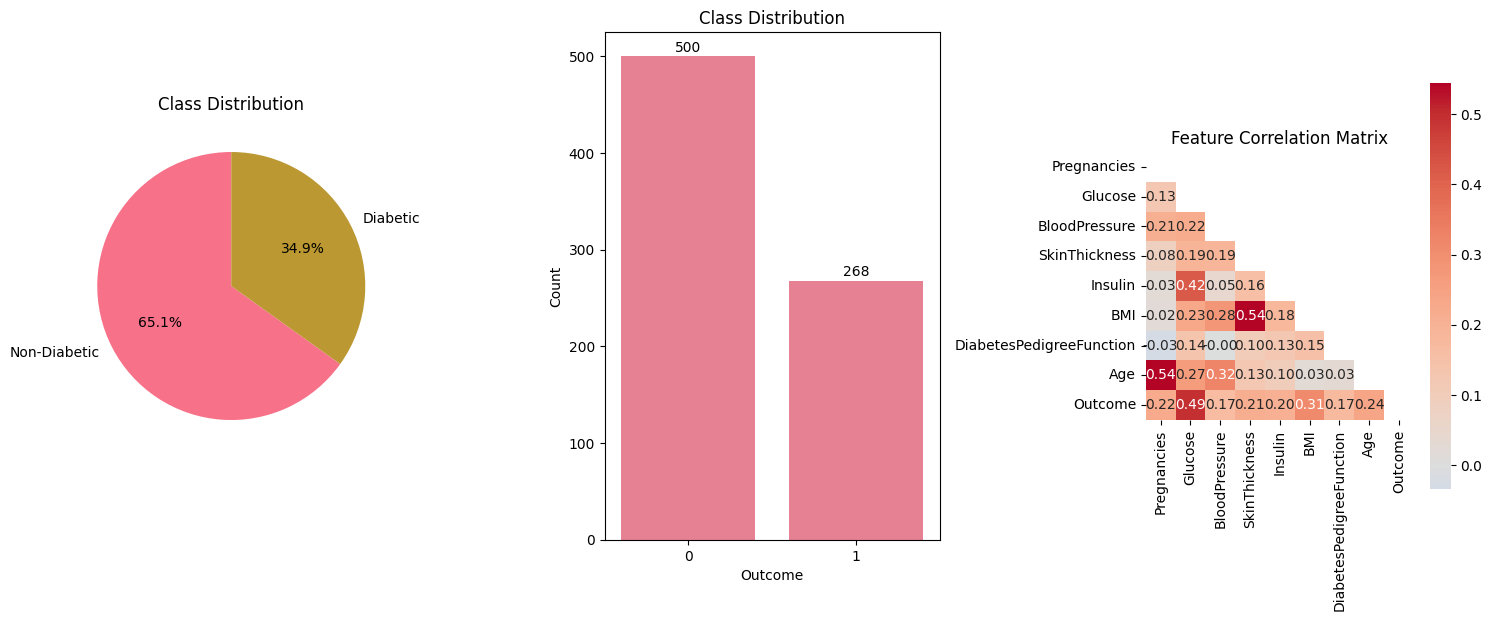

In [3]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 3, 1)
class_counts = df['Outcome'].value_counts()
plt.pie(class_counts, labels=['Non-Diabetic', 'Diabetic'], autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution')

plt.subplot(2, 3, 2)
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Outcome')
plt.ylabel('Count')
for i, count in enumerate(class_counts.values):
    plt.text(i, count + 5, str(count), ha='center')

plt.subplot(2, 3, 3)
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, mask=mask,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()

plt.show()


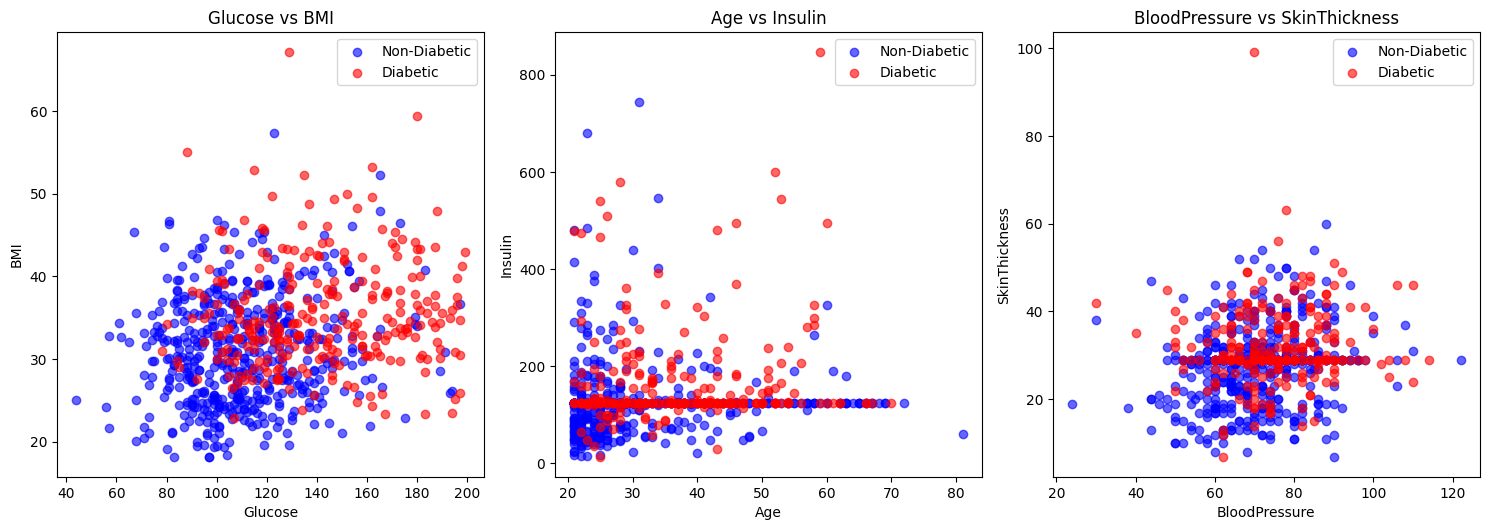

In [4]:
feature_pairs = [('Glucose', 'BMI'), ('Age', 'Insulin'), ('BloodPressure', 'SkinThickness')]

plt.figure(figsize=(15, 10))
for idx, (feature1, feature2) in enumerate(feature_pairs):
    plt.subplot(2, 3, idx + 1)
    plt.scatter(df[df['Outcome'] == 0][feature1], df[df['Outcome'] == 0][feature2], 
                alpha=0.6, label='Non-Diabetic', c='blue')
    plt.scatter(df[df['Outcome'] == 1][feature1], df[df['Outcome'] == 1][feature2], 
                alpha=0.6, label='Diabetic', c='red')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend()
    plt.title(f'{feature1} vs {feature2}')

plt.tight_layout()
plt.show()



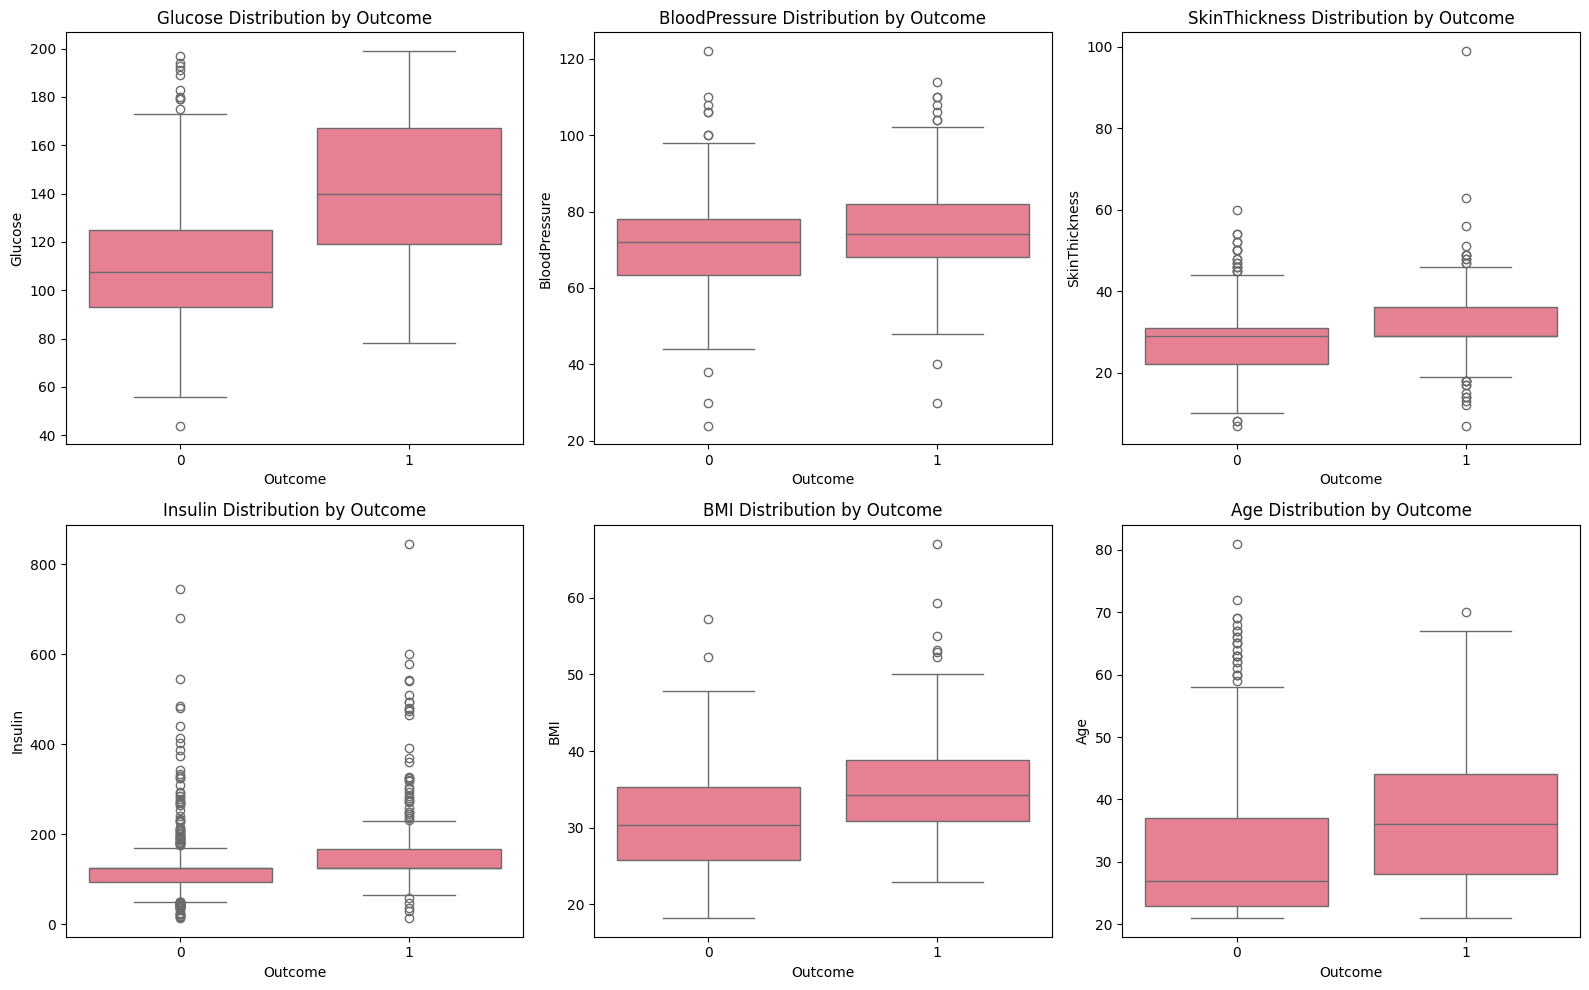

In [5]:
plt.figure(figsize=(16, 10))
features_for_boxplot = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']

for i, feature in enumerate(features_for_boxplot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Outcome', y=feature, data=df)
    plt.title(f'{feature} Distribution by Outcome')
    
plt.tight_layout()
plt.show()



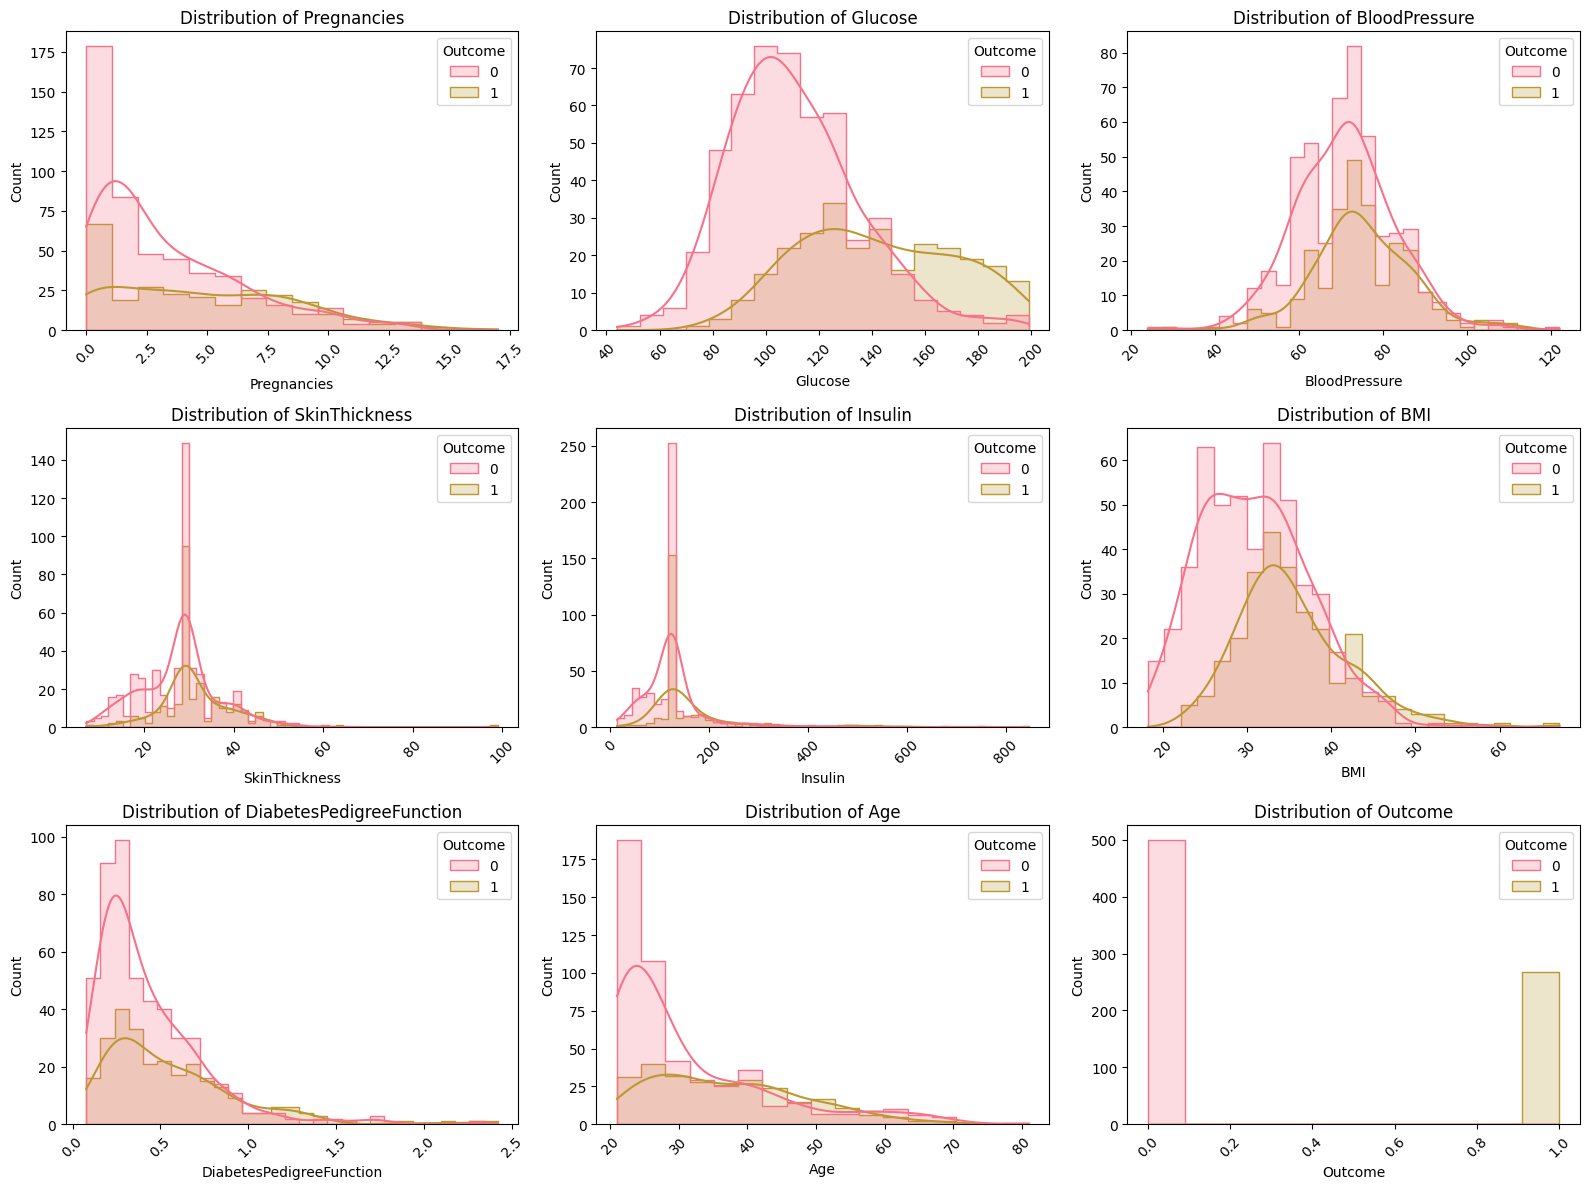

In [6]:
plt.figure(figsize=(16, 12))
for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=column, hue='Outcome', kde=True, element='step')
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()



In [7]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Features shape: (768, 8)
Target shape: (768,)
Training set: (614, 8), (614,)
Test set: (154, 8), (154,)


In [8]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]



In [9]:
rf = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=10)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]



In [10]:
cv_scores_lr = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='accuracy')
cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Results:")
print(f"Logistic Regression: {cv_scores_lr.mean():.3f} (+/- {cv_scores_lr.std() * 2:.3f})")
print(f"Random Forest: {cv_scores_rf.mean():.3f} (+/- {cv_scores_rf.std() * 2:.3f})")


Cross-Validation Results:
Logistic Regression: 0.782 (+/- 0.025)
Random Forest: 0.761 (+/- 0.056)


In [11]:
models = {
    'Logistic Regression': (y_pred_lr, y_prob_lr),
    'Random Forest': (y_pred_rf, y_prob_rf)
}

results = {}
for name, (pred, prob) in models.items():
    report = classification_report(y_test, pred, output_dict=True)
    results[name] = {
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score'],
        'ROC-AUC': roc_auc_score(y_test, prob)
    }

results_df = pd.DataFrame(results).T
print("Model Performance Comparison:")
print(results_df.round(3))

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))



Model Performance Comparison:
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression     0.708      0.600   0.500     0.545    0.813
Random Forest           0.760      0.698   0.556     0.619    0.813
Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154

Random Forest Results:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       100
           1       0.70      0.56      0.62        54

    accuracy                           0.76       154
   macro avg       0.74      0.71      0.72       154
weighted avg       0.75      0.76      0.75       154



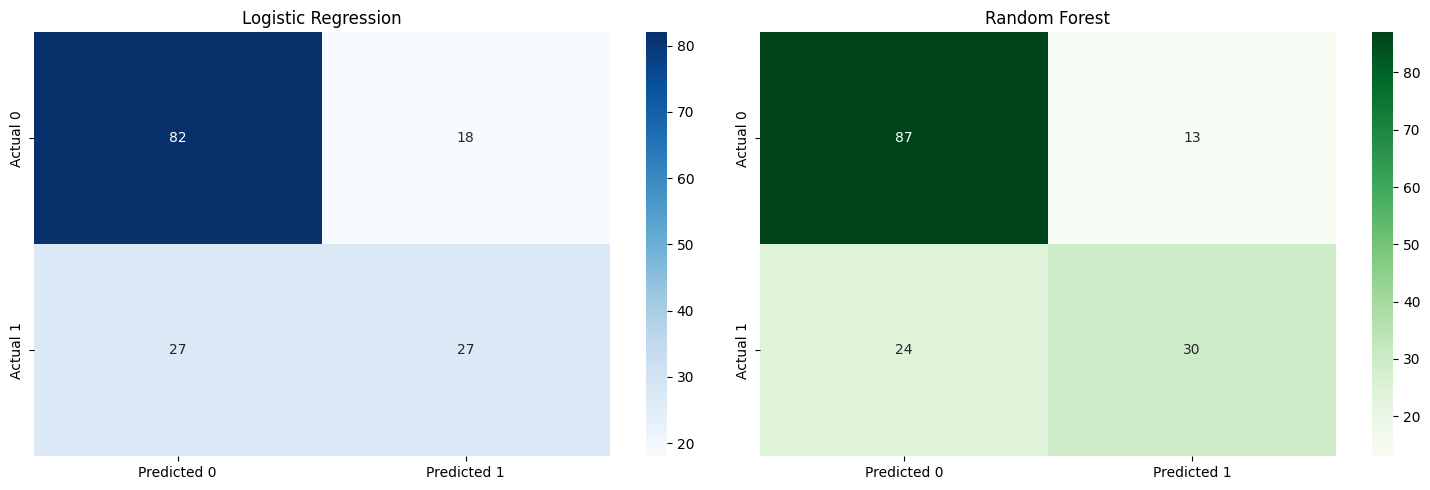

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', ax=ax1, cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
ax1.set_title('Logistic Regression')

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', ax=ax2, cmap='Greens',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
ax2.set_title('Random Forest')

plt.tight_layout()
plt.show()



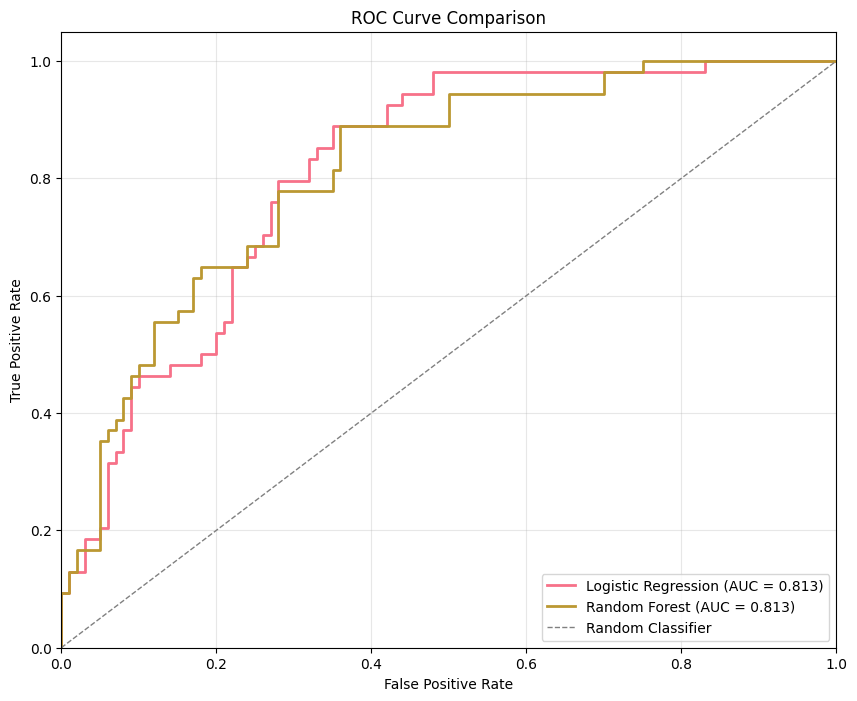

In [13]:
plt.figure(figsize=(10, 8))

for name, (pred, prob) in models.items():
    fpr, tpr, _ = roc_curve(y_test, prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()



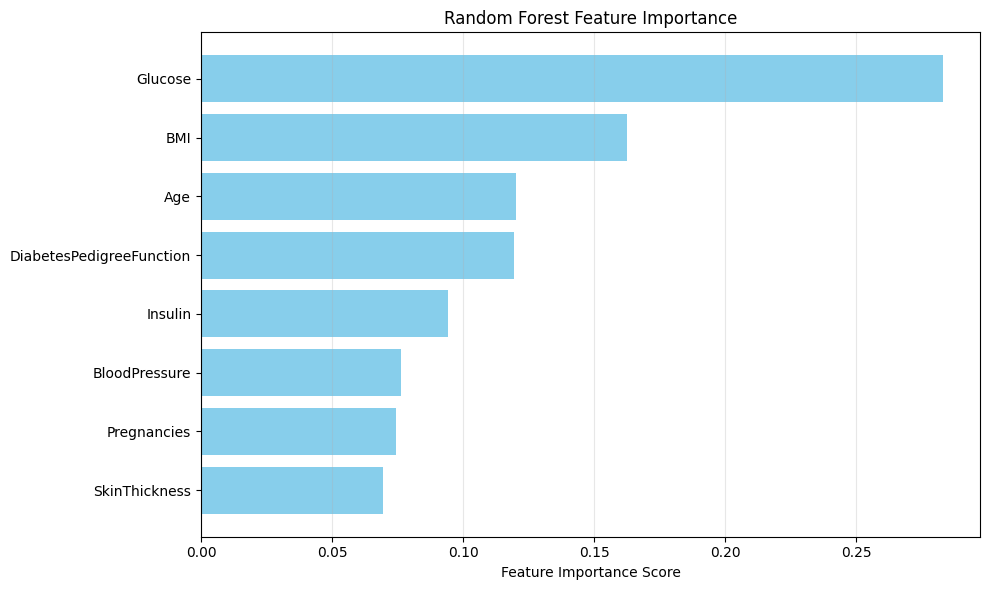

In [14]:
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
plt.xlabel('Feature Importance Score')
plt.title('Random Forest Feature Importance')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()



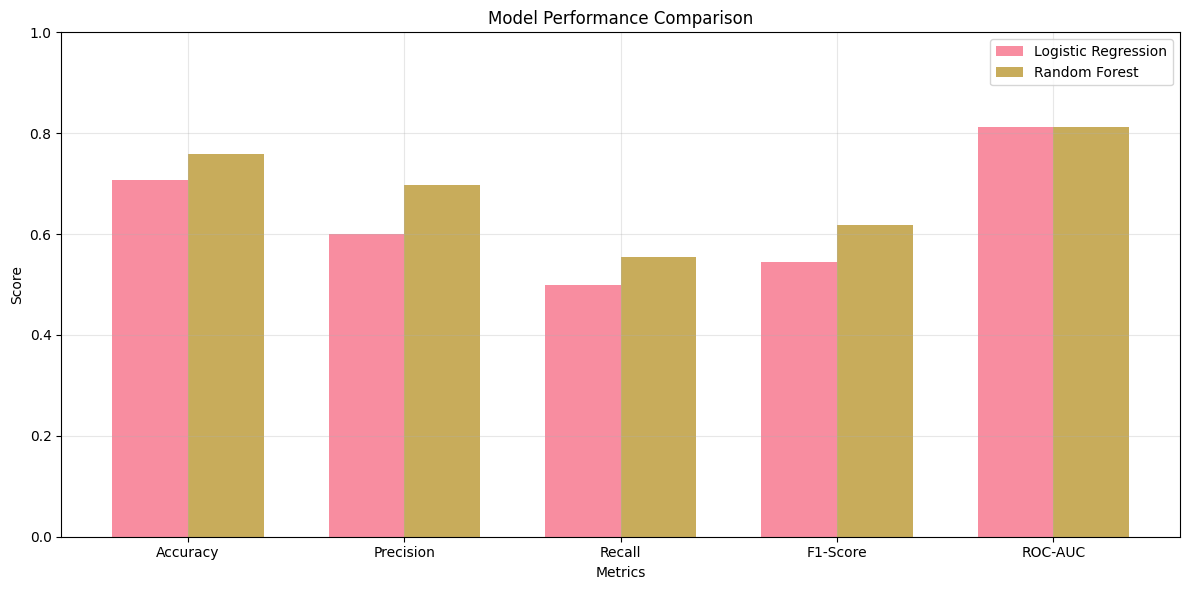

In [15]:
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x_pos = np.arange(len(metrics))

width = 0.35
plt.bar(x_pos - width/2, [results['Logistic Regression'][m] for m in metrics], 
        width, label='Logistic Regression', alpha=0.8)
plt.bar(x_pos + width/2, [results['Random Forest'][m] for m in metrics], 
        width, label='Random Forest', alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x_pos, metrics)
plt.legend()
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [16]:
print("Feature Importance Ranking:")
for i, row in feature_importance.sort_values('importance', ascending=False).iterrows():
    print(f"{i+1:2d}. {row['feature']:25s}: {row['importance']:.3f}")

print(f"Best performing model: Random Forest")
print(f"Accuracy improvement: {results['Random Forest']['Accuracy'] - results['Logistic Regression']['Accuracy']:.3f}")
print(f"Most important feature: {feature_importance.loc[feature_importance['importance'].idxmax(), 'feature']}")
print(f"Recall improvement: {results['Random Forest']['Recall'] - results['Logistic Regression']['Recall']:.3f}")



Feature Importance Ranking:
 2. Glucose                  : 0.283
 6. BMI                      : 0.163
 8. Age                      : 0.120
 7. DiabetesPedigreeFunction : 0.119
 5. Insulin                  : 0.094
 3. BloodPressure            : 0.076
 1. Pregnancies              : 0.074
 4. SkinThickness            : 0.070
Best performing model: Random Forest
Accuracy improvement: 0.052
Most important feature: Glucose
Recall improvement: 0.056
